## WHISLTER SIMULATED DATASET CLASS
_Represent a dataset of simulated whislter samples_

In [7]:
import os
import numpy as np
import h5py
import matplotlib.pyplot as plt
from tqdm import tqdm
import multiprocessing as mp

class DatasetSimulation(object):
    ''''''
    __t_res, __f_res = 0.006395061728395062, 0.15503875968992248
    __f = np.linspace(1.5e3, 9.5e3, 1000)
    __fn = 25e3
    __whistler_stats = [[1],[1.42005796],[0.27028105]]
    __noise_stats = [[0.60153252, 0.39846748],[1.1429732, 1.67713852], [0.18575808, 0.23432959]]
    
    # Initializer
    def __init__(self, dataset_sim_location, t_res=0.006395061728395062, f_res=0.15503875968992248, ext='.sim'):
        self.__dataset_sim_location = dataset_sim_location
        self.__file_extension = ext
        self.__t_res = t_res
        self.__f_res = f_res
    
    def set_resolution(self,t,f):
        self.__t_res, self.__f_res = t,f
    
    def set_frequency_range(self,f):
        self.__f = f
    
    def get_frequency_range(self):
        return self.__f
    
    def get_time_res(self):
        return self.__t_res
    
    def get_freq_res(self):
        return self.__f_res
    
    def get_fn(self):
        return self.__fn
    
    def get_extension(self):
        return self.__file_extension
    
    def get_location(self):
        return self.__dataset_sim_location
    def get_whistler_stats(self):
        return self.__whistler_stats
    ################## WHISTLER
    def whistler_trace(self, An, D0):
        """generate the whistler trace
        Params
            An: normalised equatorial electron gyrofrequency
            D0: zero dispersion
            fn: nose frequency
            f: frequency range
        return
            t: time range
            """
        t = (D0/((1+An)*np.sqrt(self.__f)))*(((1+An)-(3*An-1)*(self.__f/self.__fn))/(1-An*self.__f/self.__fn))
        return np.array(t)

    def whistler_sim(self, An, D0, magnitude):
        """Generate a 2D representation of the whistler trace
        Params
            An: normalised equatorial electron gyrofrequency
            D0: zero dispersion
            fn: nose frequency
            f: frequency range
        return
            t: time range"""
        t = self.whistler_trace(An=An, D0=D0)
        t_trans, f_trans = (t-t.min())/self.__t_res, (self.__f-self.__f.min())*1e-3/self.__f_res
#         print(t_trans.shape, f_trans.shape)
        t_trans, f_trans = t_trans.astype(np.int), f_trans.astype(np.int) 
        coor = np.array([(t,f) for t,f in zip(t_trans, f_trans)])
        data = np.zeros((t_trans.max()+1,f_trans.max()+1))
#         print(data.shape, coor.shape)
        for x,y in coor:
            data[x,y] = magnitude
        return data.T
    
    def whistler_sim_D0(self, An, D0, magnitude):
        data = self.whistler_sim(An,D0[0],magnitude)
        for d0 in D0[1:]:
            f,t = data.shape
            data += self.whistler_sim(An,d0,magnitude)[:f,:t]
        f,t = data.shape
        for i in range(t):
            for j in range(f):
                if data[j,i] >= magnitude:
                    data[j,i] = magnitude
        return data
    
    def whistler_file(self, An, D0, magnitude):
        """Generate a whistler simulation and save it"""
        An = np.round(An,4)
        D0 = np.round(D0,2)
        magnitude = np.round(magnitude,2)
        data = self.whistler_sim(An=An, D0=D0, magnitude=magnitude)
        a,d,m,fn,f_min,f_max = str(An), str(D0), str(magnitude),str(int(self.__fn)), str(int(self.__f.min())), str(int(self.__f.max()))
        file_name = os.path.join(self.__dataset_sim_location, a+'_'+d+'_'+m+'_'+fn+'_'+f_min+'_'+f_max+self.__file_extension)
        file = h5py.File(file_name, 'w')
        file.create_dataset(file_name, data.shape, np.float32, compression='gzip', data=data)
        file.close()
    
    def load_whistler_file(self, An, D0, magnitude):
        """Load a whistler simulation file"""
        a,d,m,fn,f_min,f_max = str(An), str(D0), str(magnitude),str(int(self.__fn)), str(int(self.__f.min())), str(int(self.__f.max()))
        file_name = os.path.join(self.__dataset_sim_location, a+'_'+d+'_'+m+'_'+fn+'_'+f_min+'_'+f_max+self.__file_extension)
        try:
            file = h5py.File(file_name, 'r+')
        except Exception as e:
            print('File: %s. Exception: %s'%(file,e))
        file_data = np.empty(file[file_name].shape,dtype=np.float64)
        file[file_name].read_direct(file_data)
        data = np.asarray(file_data)
        file.close()
        return data
    
    def whistler_file_(self,param):
        self.whistler_file(An=param[0], D0=param[1], magnitude=param[2])
        
    def generate_whislters(self, An_dec=3, D0_dec=1):
        """Generate all whistler simulation file"""
        An_min, An_max = 0.35, 0.45
        An = np.linspace(An_min, An_max, int((An_max-An_min)/10**(-An_dec))+1)
        D0_min, D0_max = 20, 80
        D0 = np.linspace(D0_min, D0_max, int((D0_max-D0_min)/10**(-D0_dec))+1)
        __stats = self.__whistler_stats
        magnitude = [np.array([w*(m+k*s) for w,m,s in zip(__stats[0],__stats[1],__stats[2])]).sum() for k in [4,5,6]]
        # use multiprocessing
        pool = mp.Pool(mp.cpu_count())
        params = [(a,d,m) for a in An for d in D0 for m in magnitude] # define parameters
        for _ in tqdm(pool.imap_unordered(self.whistler_file_, params), total=len(params)):
            pass
        pool.close()
        
    ################## NOISE
    def noise_sim(self, mean, std):
        t = np.linspace(0,0.8,len(self.__f))
        t_trans, f_trans = (t-t.min())/self.__t_res, (self.__f-self.__f.min())*1e-3/self.__f_res
        t_trans, f_trans = t_trans.astype(np.int), f_trans.astype(np.int) 
        data = np.random.normal(mean, std, (t_trans.max()+1)*(f_trans.max()+1))
        data = data.reshape((f_trans.max()+1,t_trans.max()+1))
        return data
    
    def noise_file(self, mean, std):
        """Generate a noise simulation and save it"""
        mean, std = np.round(mean,3), np.round(std,3)
        data = self.noise_sim(mean=mean, std=std)
        u,s = str(mean), str(std)
        file_name = os.path.join(self.__dataset_sim_location, u+'_'+s+self.__file_extension)
        file = h5py.File(file_name, 'w')
        file.create_dataset(file_name, data.shape, np.float32, compression='gzip', data=data)
        file.close()
        
    def noise_file_(self,param):
        self.noise_file(mean=param[0], std=param[1])
        
    def generate_noise(self, dec=3):
        """Generate all noise simulation file"""
        mean_mean, mean_std = 1.356, 0.254
        std_mean, std_std = 0.456, 0.056
        mean = np.linspace(mean_mean-mean_std, mean_mean+mean_std, int(2*mean_std/10**(-dec))+1)
        std = np.linspace(std_mean-std_std, std_mean+std_std, int(2*std_std/10**(-dec))+1)
        # use multiprocessing
        pool = mp.Pool(mp.cpu_count())
        params = [(u,s) for u in mean for s in std] # define parameters
        for _ in tqdm(pool.imap_unordered(self.noise_file_, params), total=len(params)):
            pass
        pool.close() 
        
    def load_noise_file(self, mean, std):
        """Load a whistler simulation file"""
        u,s = str(mean), str(std)
        file_name = os.path.join(self.__dataset_sim_location, u+'_'+s+self.__file_extension)
        try:
            file = h5py.File(file_name, 'r+')
        except Exception as e:
            print('File: %s. Exception: %s'%(file,e))
        file_data = np.empty(file[file_name].shape,dtype=np.float64)
        file[file_name].read_direct(file_data)
        data = np.asarray(file_data)
        file.close()
        return data
    
    ################## NOISY WHISTLERS
    def noisy_whistler_sim(self, An, D0, magnitude, mean, std):
        t = self.whistler_trace(An=An, D0=D0)
        t_trans, f_trans = (t-t.min())/self.__t_res, (self.__f-self.__f.min())*1e-3/self.__f_res
        t_trans, f_trans = t_trans.astype(np.int), f_trans.astype(np.int) 
        coor = np.array([(t,f) for t,f in zip(t_trans, f_trans)])
        data = np.zeros((t_trans.max()+1,f_trans.max()+1))
        for x,y in coor:
            data[x,y] = magnitude
        data = data.T
        noise = np.random.normal(mean, std, (t_trans.max()+1)*(f_trans.max()+1))
        noise = noise.reshape((f_trans.max()+1,t_trans.max()+1))
        return data+noise
    
    def noisy_whistler_file(self, An, D0, magnitude, mean, std):
        """Generate a noise simulation and save it"""
        An = np.round(An,4)
        D0 = np.round(D0,2)
        magnitude = np.round(magnitude,2)
        mean, std = np.round(mean,3), np.round(std,3)
        data = self.noisy_whistler_sim(An=An, D0=D0, magnitude=magnitude,mean=mean, std=std)
        a,d,m,fn,f_min,f_max = str(An), str(D0), str(magnitude),str(int(self.__fn)), str(int(self.__f.min())), str(int(self.__f.max()))
        u,s = str(mean), str(std)
        file_name = os.path.join(self.__dataset_sim_location, a+'_'+d+'_'+m+'_'+fn+'_'+f_min+'_'+f_max+'_'+u+'_'+s+self.__file_extension)
        file = h5py.File(file_name, 'w')
        file.create_dataset(file_name, data.shape, np.float32, compression='gzip', data=data)
        file.close()
        
    def noisy_whistler_file_(self,param):
        self.noisy_whistler_file(An=param[0], D0=param[1], magnitude=param[2],mean=param[3], std=param[4])
        
    def generate_noisy_whistler(self, An_dec=3, D0_dec=1, dec=3):
        """Generate all whistler simulation file"""
        An_min, An_max = 0.35, 0.45
        An = np.linspace(An_min, An_max, int((An_max-An_min)/10**(-An_dec))+1)
        D0_min, D0_max = 20, 80
        D0 = np.linspace(D0_min, D0_max, int((D0_max-D0_min)/10**(-D0_dec))+1)
        __stats = self.__whistler_stats
        magnitude = [np.array([w*(m+k*s) for w,m,s in zip(__stats[0],__stats[1],__stats[2])]).sum() for k in [4,5,6]]
        mean_mean, mean_std = 1.356, 0.254
        std_mean, std_std = 0.456, 0.056
        mean = np.random.choice(np.linspace(mean_mean-mean_std, mean_mean+mean_std, int(2*mean_std/10**(-dec))+1))
        std = np.random.choice(np.linspace(std_mean-std_std, std_mean+std_std, int(2*std_std/10**(-dec))+1))
        # use multiprocessing
        pool = mp.Pool(mp.cpu_count())
        params = [(a,d,m,mean,std) for a in An for d in D0 for m in magnitude] # define parameters
        for _ in tqdm(pool.imap_unordered(self.noisy_whistler_file_, params), total=len(params)):
            pass
        pool.close() 
        
    def load_noise_file(self, An, D0, magnitude, mean, std):
        """Load a whistler simulation file"""
        a,d,m,fn,f_min,f_max = str(An), str(D0), str(magnitude),str(int(self.__fn)), str(int(self.__f.min())), str(int(self.__f.max()))
        u,s = str(mean), str(std)
        file_name = os.path.join(self.__dataset_sim_location, a+'_'+d+'_'+m+'_'+fn+'_'+f_min+'_'+f_max+'_'+u+'_'+s+self.__file_extension)
        try:
            file = h5py.File(file_name, 'r+')
        except Exception as e:
            print('File: %s. Exception: %s'%(file,e))
        file_data = np.empty(file[file_name].shape,dtype=np.float64)
        file[file_name].read_direct(file_data)
        data = np.asarray(file_data)
        file.close()
        return data

(1000,) (1000,)
(184, 52) (1000, 2)


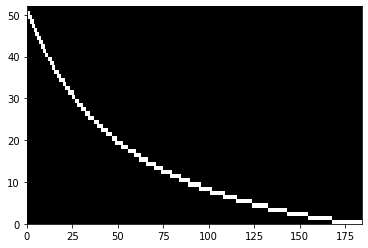

In [8]:
# dataset_sim_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','datasets', 'simulations', 'simple' ,'whistler')
# dataset_sim = DatasetSimulation(dataset_sim_loc, 0.006395061728395062, 0.15503875968992248)
# kernel = dataset_sim.whistler_sim(An=0.35, D0=80, magnitude=1)
# plt.pcolormesh(kernel, cmap='gray')

In [ ]:
# # whistlers
# dataset_sim_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','datasets', 'simulations', 'simple' ,'whistler')
# dataset_sim = DatasetSimulation(dataset_sim_loc, 0.006395061728395062, 0.15503875968992248)
# dataset_sim.generate_whislters()
# # noise
# dataset_sim_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','datasets', 'simulations', 'simple' ,'noise')
# dataset_sim = DatasetSimulation(dataset_sim_loc, 0.006395061728395062, 0.15503875968992248)
# dataset_sim.generate_noise()
# # noisy whistlers
# dataset_sim_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','datasets', 'simulations', 'simple' ,'noisy whsitler')
# dataset_sim = DatasetSimulation(dataset_sim_loc, 0.006395061728395062, 0.15503875968992248)
# dataset_sim.generate_noisy_whistler()

In [3]:
# dataset_sim_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','datasets', 'simulations', 'simple' ,'whistler')
# dataset_sim = DatasetSimulation(dataset_sim_loc, 0.006395061728395062, 0.15503875968992248)
# # dataset_sim.whistler_file(An=0.35, D0=20)
# # plt.pcolormesh(dataset_sim.load_whistler_file(An=0.35, D0=20))
# dataset_sim.generate_whislters()
# dataset_sim.generate_noise()
# whistler = dataset_sim.whistler_sim(An=0.35, D0=20, magnitude=3)
# noise = dataset_sim.noise_sim(1.356,0.456)
# noisy_whistler = dataset_sim.noisy_whistler_sim(An=0.35, D0=39, magnitude=3, mean=1.356,std=0.456)
# print(whistler.shape, noise.shape)
# plt.figure(figsize=(3,2))
# plt.pcolormesh(whistler, cmap='jet')
# plt.figure(figsize=(3,2))
# plt.pcolormesh(noise, cmap='jet')
# plt.figure(figsize=(3,2))
# plt.pcolormesh(noise+whistler, cmap='jet')
# plt.figure(figsize=(3,2))
# plt.pcolormesh(noisy_whistler, cmap='jet')